In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator

In [46]:
df_train = pd.read_csv('df_train.csv')
df_test  = pd.read_csv('df_test.csv')

In [47]:
# df_train

In [54]:
df_train[['GarageCars']].nunique()

GarageCars    5
dtype: int64

## Explonatory Data Analysis

Independent variable (Target) is `SalePrice`

In [32]:
df_train.SalePrice.dtypes

dtype('int64')

1.8828757597682129


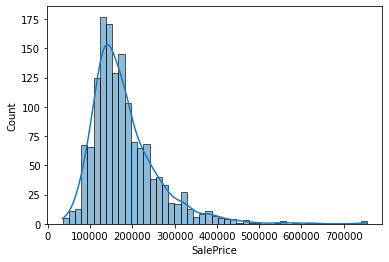

In [33]:
sns.histplot(data=df_train,x="SalePrice", kde=True)
print(df_train.SalePrice.skew())

We will adjust skewness later

In [34]:
numerical_features = list(df_train.select_dtypes('number').columns[:-1])
categorical_features = list(df_train.select_dtypes('object').columns)

print('The number of numerical features is ', len(numerical_features)) 
print('The number of catergorical features is ', len(categorical_features)) 

The number of numerical features is  33
The number of catergorical features is  28


### Numerical data

we separate numerical features whose number of unique values <= 30 

In [35]:
numerical_features_less_30 = list(df_train[numerical_features].nunique()
                              .iloc[df_train[numerical_features].nunique().values<=30].index)
numerical_features_more_30 = [x for x in numerical_features if x not in numerical_features_less_30]

#### Numerical features whose number of unique values is $>30$ 

In [36]:
# f = pd.melt(df_train[numerical_features_more_30])
# fg = sns.FacetGrid(f, col='variable',  col_wrap=3,sharex=False, sharey=False,height=3.5, aspect=1.2)
# fg.map(sns.histplot, "value")

In [37]:
numerical_features_more_30 =['LotArea', 'TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea']

Adjust skewness

In [38]:
df_train[numerical_features_more_30].describe().min()

LotArea        1300.0
TotalBsmtSF       0.0
1stFlrSF        334.0
GrLivArea       334.0
GarageArea        0.0
dtype: float64

In [39]:
adjusted_features = numerical_features_more_30 + ['SalePrice']


In [40]:
df_train.replace({'TotalBsmtSF':{0:1}, 'GarageArea':{0: 1}}, inplace=True)

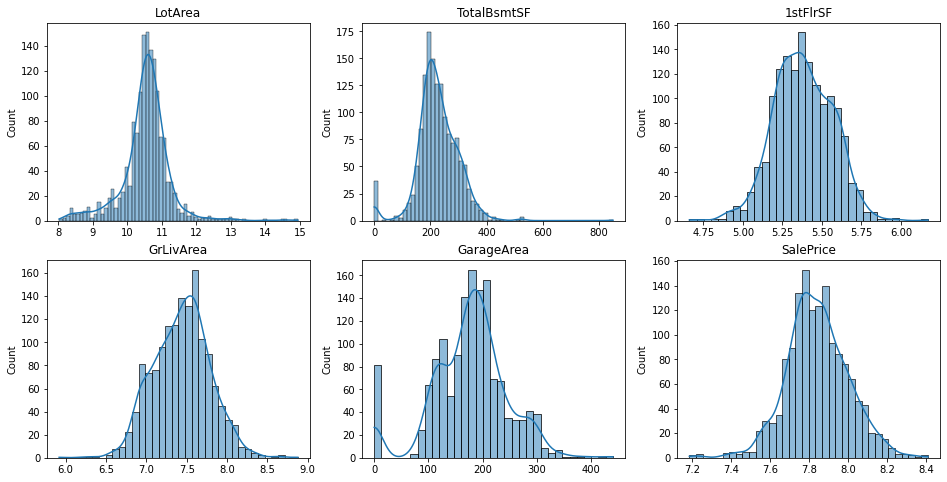

In [41]:
nrows = len(adjusted_features)//3 
fig, axs = plt.subplots(ncols=3,nrows=nrows,figsize=(16,8))
for i in range(nrows):
    for j in range(3):
        ftr = adjusted_features[3*i+j]
        xt, _ = stats.boxcox(df_train[ftr])
        sns.histplot(data=xt, kde=True,ax=axs[i][j])
        axs[i][j].set_title(ftr)
        df_train[ftr] = xt

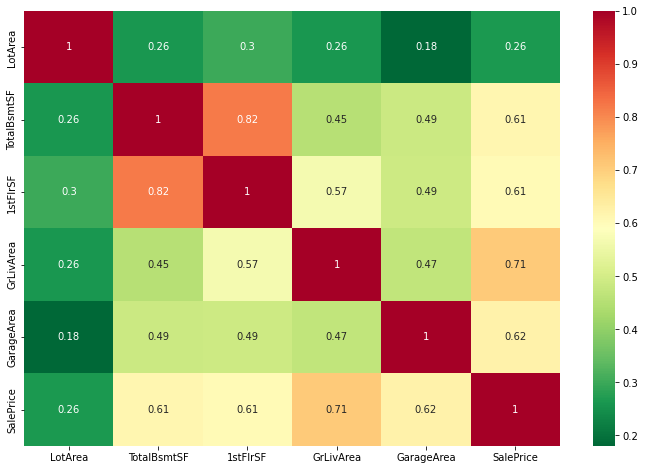

In [62]:
corrmat = df_train[adjusted_features].corr()
plt.figure(figsize=(12,8))
g = sns.heatmap(corrmat,annot=True,cmap="RdYlGn_r")

We decided to drop `LotArea` are less than 0.5,  these two predictors before fitting the model.

In [63]:
adjusted_features.remove('LotArea')

In [64]:
adjusted_features

['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea', 'SalePrice']

### Categorical

In [ ]:
nrows = len(categorical)//3 
fig, axs = plt.subplots(ncols=3,nrows=nrows,figsize=(16,8))
for i in range(nrows):
    for j in range(3):
        ftr = adjusted_features[3*i+j]
        sns.histplot(data=xt, kde=True,ax=axs[i][j])
        axs[i][j].set_title(ftr)


In [56]:
# This function presents all the boxplots of categorical preditors with SalePrice
def srt_box(y, df):
    fig, axes = plt.subplots(16, 3, figsize=(20, 70))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['category']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=True)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

In [58]:
categorical = categorical_features + numerical_features_less_30
df_categorical = df_train[categorical].astype('category',copy=False)
df_categorical['SalePrice'] = df_train['SalePrice']
df_categorical.shape

(1460, 47)

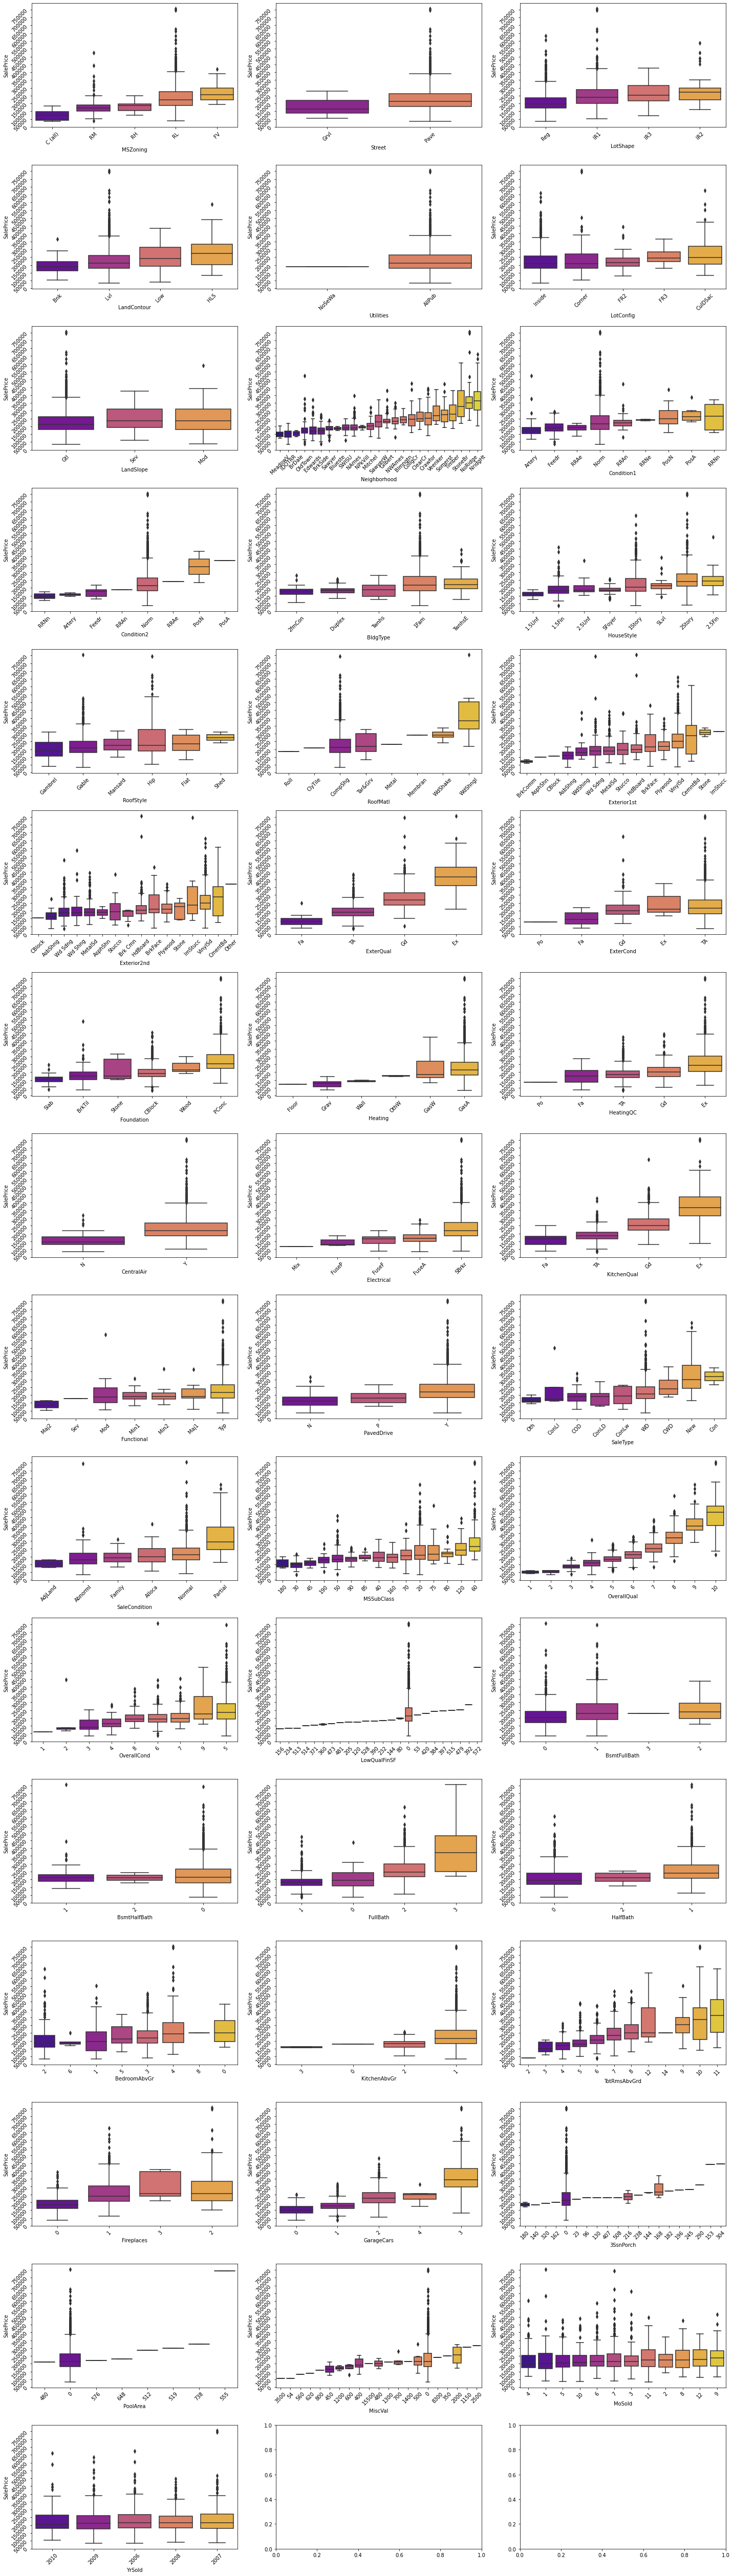

In [59]:
srt_box('SalePrice', df_categorical)

In [69]:
# Select potential categorical predictors based on the boxplots above
categorical_features = ['MSZoning', 'Neighborhood','ExterQual','CentralAir','KitchenQual','OverallQual']

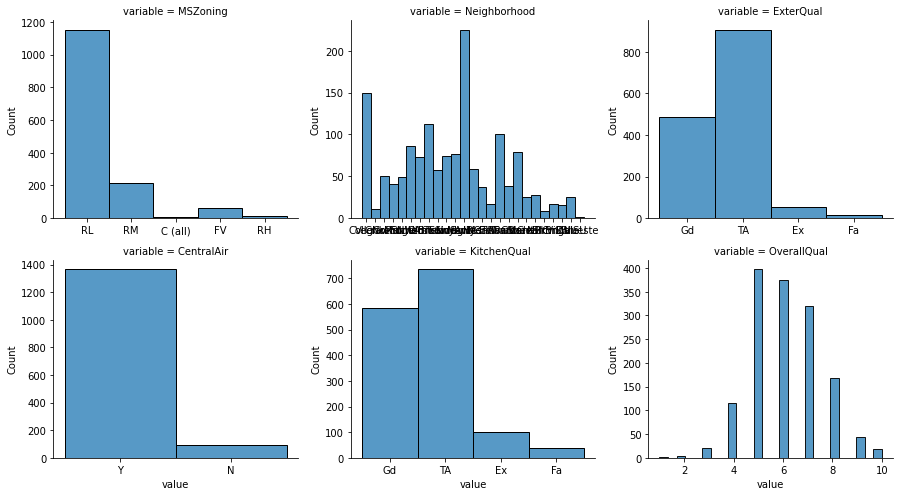

In [70]:
f = pd.melt(df_train[categorical_features])
fg = sns.FacetGrid(f, col='variable',  col_wrap=3,sharex=False, sharey=False,height=3.5, aspect=1.2)
fg.map(sns.histplot, "value")

In [71]:
categorical_features = [ 'Neighborhood','ExterQual','KitchenQual','OverallQual']

kept_features = categorical_features + adjusted_features

df_train = df_train[kept_features]

In [76]:
df_train

,Neighborhood,ExterQual,KitchenQual,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,CollgCr,Gd,Gd,7,856,856,1710,548,208500
1,Veenker,TA,TA,6,1262,1262,1262,460,181500
2,CollgCr,Gd,Gd,7,920,920,1786,608,223500
3,Crawfor,TA,Gd,7,756,961,1717,642,140000
4,NoRidge,Gd,Gd,8,1145,1145,2198,836,250000
...,...,...,...,...,...,...,...,...,...
1455,Gilbert,TA,TA,6,953,953,1647,460,175000
1456,NWAmes,TA,TA,6,1542,2073,2073,500,210000
1457,Crawfor,Ex,Gd,7,1152,1188,2340,252,266500
1458,NAmes,TA,Gd,5,1078,1078,1078,240,142125


In [73]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')


In [78]:
enc.fit_transform(df_train).dtype

dtype('float64')

In [74]:
train_dtypes = df_train.dtypes

df_train = pd.DataFrame(enc.fit_transform(df_train), 
                        index= df_train.index, 
                        columns = df_train.columns).astype(train_dtypes.to_dict())


ValueError: Shape of passed values is (1460, 1), indices imply (1460, 9)

In [72]:
df_train.dtypes

Neighborhood    object
ExterQual       object
KitchenQual     object
OverallQual      int64
TotalBsmtSF      int64
1stFlrSF         int64
GrLivArea        int64
GarageArea       int64
SalePrice        int64
dtype: object

In [22]:
df_train

,Neighborhood,ExterQual,KitchenQual,OverallQual,GarageCars,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,4,4,4,7,2,0.642487,0.404844,0.525656,1.090793,0.483517
1,4,3,3,6,2,0.873733,0.490420,0.451188,0.922722,0.455943
2,4,4,4,7,2,0.681190,0.420764,0.536259,1.204217,0.497011
3,4,3,4,7,3,0.580067,0.430414,0.526653,1.268096,0.402928
4,5,4,4,8,3,0.810360,0.469126,0.586099,1.627631,0.518219
...,...,...,...,...,...,...,...,...,...,...
1455,3,3,3,6,2,0.700788,0.428563,0.516474,0.922722,0.448579
1456,3,3,3,6,2,1.016395,0.592558,0.572202,0.999381,0.484920
1457,4,5,4,7,1,0.814220,0.477222,0.600778,0.516056,0.529967
1458,3,3,4,5,1,0.772950,0.455834,0.413044,0.492132,0.406027


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(df_train)
df_train = pd.DataFrame(data,
                        columns=df_train.columns,
                        index=df_train.index)
df_train

,Neighborhood,ExterQual,KitchenQual,OverallQual,GarageCars,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,0.713481,1.052302,0.735994,0.651479,0.311725,-0.412968,-0.816987,0.541410,0.364320,0.604025
1,0.713481,-0.689604,-0.771091,-0.071836,0.311725,0.535810,0.438662,-0.394553,-0.044421,0.246400
2,0.713481,1.052302,0.735994,0.651479,0.311725,-0.254175,-0.583384,0.674684,0.640161,0.779040
3,0.713481,-0.689604,0.735994,0.651479,1.650307,-0.669070,-0.441805,0.553950,0.795512,-0.441204
4,1.478862,1.052302,0.735994,1.374795,1.650307,0.275796,0.126223,1.301102,1.669881,1.054106
...,...,...,...,...,...,...,...,...,...,...
1455,-0.051899,-0.689604,-0.771091,-0.071836,0.311725,-0.173766,-0.468959,0.426012,-0.044421,0.150888
1456,-0.051899,-0.689604,-0.771091,-0.071836,0.311725,1.121135,1.937317,1.126441,0.142011,0.622226
1457,0.713481,2.794208,0.735994,0.651479,-1.026858,0.291634,0.245005,1.485605,-1.033409,1.206486
1458,-0.051899,-0.689604,0.735994,-0.795151,-1.026858,0.122306,-0.068814,-0.873975,-1.091592,-0.401008


### Outliers

In [39]:
# Plotting numerical features with polynomial order to detect outliers.
def srt_reg(y, df):
    fig, axes = plt.subplots(4, 3, figsize=(10,12))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['number']).columns, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='chocolate',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

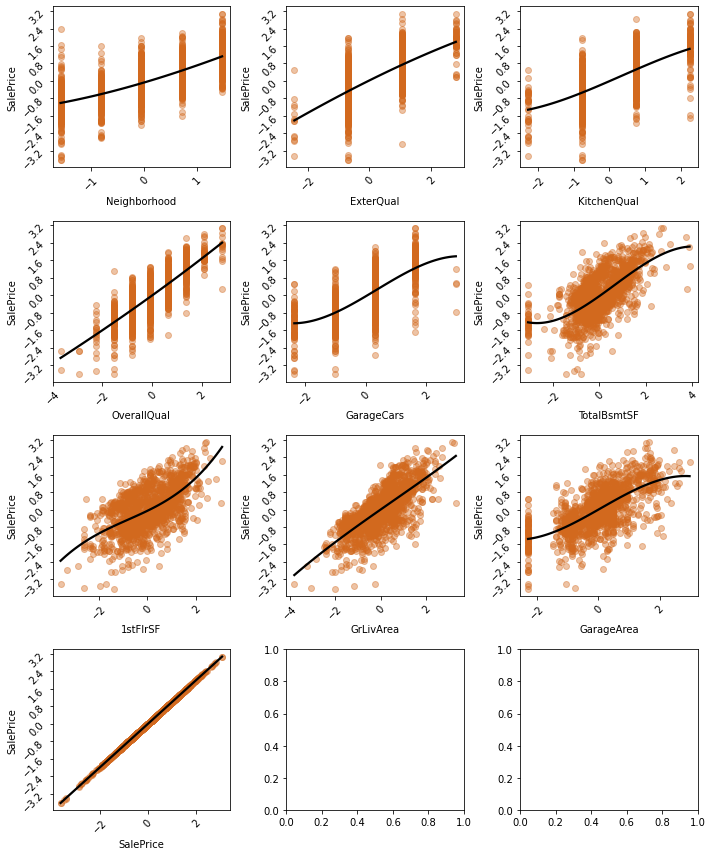

In [40]:
srt_reg('SalePrice', df_train)

In [41]:
# Dropping some outliers by identifying them from above
df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] > 5)].index)
df_train = df_train.drop(df_train[(df_train['GarageArea'] > 3)].index)

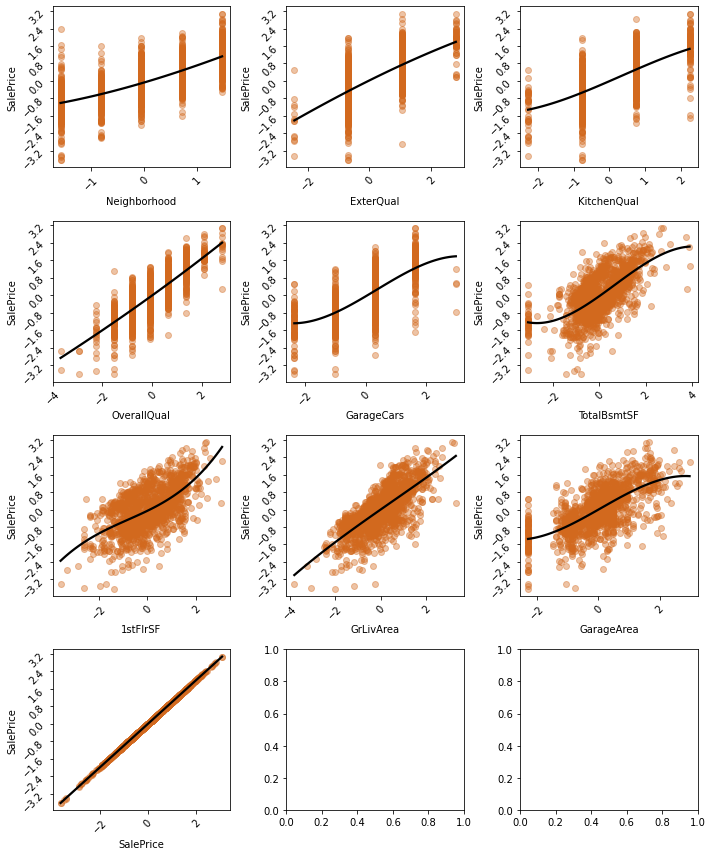

In [42]:
srt_reg('SalePrice', df_train)